# Dataset Cleaning
This notebook pollutes a train set by randomly flipping labels, then prioritizes train instances to check to fix them.

In [13]:
import argparse
from copy import deepcopy
import os
import sys
sys.path.insert(0, os.getcwd() + '/../../')  # for influence_boosting

import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import clone
from sklearn.metrics import accuracy_score

import sexee
from util import model_util, data_util, exp_util
from influence_boosting.influence.leaf_influence import CBLeafInfluenceEnsemble

In [14]:
def num_labels_to_flip(dataset):

    if dataset == 'adult':
        result = 13000  # 15000
    elif dataset == 'hospital':
        result = 6000
    elif dataset == 'amazon':
        result = 11000  # 12000
    elif dataset == 'upselling':
        result = 3500
    elif dataset == 'breast':
        result = 90
    elif dataset == 'medifor':
        result = 1500
    elif dataset == 'medifor2':
        result = 1100
    else:
        exit('{} dataset not available'.format(dataset))

    return result


def interval_performance(ckpt_ndx, fix_ndx, noisy_ndx, clf, data, acc_test_noisy):

    X_train, y_train, X_test, y_test = data

    accs = [acc_test_noisy]
    checked_pct = [0]
    fix_pct = [0]

    for n_checked, n_fix in tqdm.tqdm(ckpt_ndx):
        fix_indices = fix_ndx[:n_fix]

        semi_noisy_ndx = np.setdiff1d(noisy_ndx, fix_indices)
        y_train_semi_noisy = data_util.flip_labels_with_indices(y_train, semi_noisy_ndx)

        model_semi_noisy = clone(clf).fit(X_train, y_train_semi_noisy)
        acc_test = accuracy_score(y_test, model_semi_noisy.predict(X_test))

        accs.append(acc_test)
        checked_pct.append(float(n_checked / len(y_train)))
        fix_pct.append(float(n_fix / len(noisy_ndx)))

    return checked_pct, accs, fix_pct


def record_fixes(train_order, noisy_ndx, y_train, interval):

    fix_ndx = []
    ckpt_ndx = []
    checked = 0
    snapshot = 1

    for train_ndx in train_order:
        if train_ndx in noisy_ndx:
            fix_ndx.append(train_ndx)
        checked += 1

        if float(checked / len(y_train)) >= (snapshot * interval):
            ckpt_ndx.append((checked, len(fix_ndx)))
            snapshot += 1
    fix_ndx = np.array(fix_ndx)

    return ckpt_ndx, fix_ndx

Define the different methods for prioritizing train instances to check:

In [3]:
def sexee_method(explainer, noisy_ndx, y_train, points=10):

    train_weight = explainer.get_train_weight()
    n_check = len(train_weight)
    train_order = [train_ndx for train_ndx, weight in train_weight]
    interval = (len(train_weight) / len(y_train)) / points
    ckpt_ndx, fix_ndx = record_fixes(train_order, noisy_ndx, y_train, interval)

    return ckpt_ndx, fix_ndx, interval, n_check


def random_method(noisy_ndx, y_train, interval, to_check=1, random_state=69):

    n_train = len(y_train)

    assert to_check <= n_train, 'to_check > n_train!'
    if isinstance(to_check, int):
        n_check = to_check
    else:
        exit('to_check not int')

    np.random.seed(random_state + 1)  # +1 to avoid choosing the same indices as the noisy labels
    train_order = np.random.choice(n_train, size=n_check, replace=False)
    ckpt_ndx, fix_ndx = record_fixes(train_order, noisy_ndx, y_train, interval)
    return ckpt_ndx, fix_ndx


def loss_method(noisy_ndx, y_train_proba, y_train, interval, to_check=1):

    n_train = len(y_train)

    assert to_check <= n_train, 'to_check > n_train!'
    if isinstance(to_check, int):
        n_check = to_check
    else:
        exit('to_check not int')

    y_probas = model_util.positive_class_proba(y_train, y_train_proba)
    y_ll = exp_util.instance_log_loss(y_probas, y_train)
    train_order = np.argsort(y_ll)[:n_check]  # ascending order
    ckpt_ndx, fix_ndx = record_fixes(train_order, noisy_ndx, y_train, interval)
    return ckpt_ndx, fix_ndx


def influence_method(explainer, noisy_ndx, X_train, y_train, y_train_noisy, interval, to_check=1):

    n_train = len(y_train)

    assert to_check <= n_train, 'to_check > n_train!'
    if isinstance(to_check, int):
        n_check = to_check
    else:
        exit('to_check not int')

    influence_scores = []
    buf = deepcopy(explainer)
    for i in tqdm.tqdm(range(len(X_train))):
        explainer.fit(removed_point_idx=i, destination_model=buf)
        influence_scores.append(buf.loss_derivative(X_train[[i]], y_train_noisy[[i]])[0])
    influence_scores = np.array(influence_scores)

    # sort by absolute value
    train_order = np.argsort(np.abs(influence_scores))[::-1][:n_check]
    ckpt_ndx, fix_ndx = record_fixes(train_order, noisy_ndx, y_train, interval)
    return ckpt_ndx, fix_ndx

Compare how efficient each method is at detecting mislabeled train instances and how the chosen train instances impact test accuracy.

In [12]:
def noise_detection(model_type='lgb', encoding='tree_path', dataset='iris', n_estimators=100, random_state=69, timeit=False, inf_k=None):

    # get model and data
    clf = model_util.get_classifier(model_type, n_estimators=n_estimators, random_state=random_state)
    X_train, X_test, y_train, y_test, label = data_util.get_data(dataset, random_state=random_state, data_dir='../../data/')
    data = X_train, y_train, X_test, y_test

    print('train instances: {}'.format(len(X_train)))
    print('test instances: {}'.format(len(X_test)))

    # add noise
    y_train_noisy, noisy_ndx = data_util.flip_labels(y_train, k=num_labels_to_flip(dataset), random_state=random_state)
    noisy_ndx = np.array(sorted(noisy_ndx))
    print('num noisy labels: {}'.format(len(noisy_ndx)))

    # train a tree ensemble
    model = clone(clf).fit(X_train, y_train)
    model_noisy = clone(clf).fit(X_train, y_train_noisy)

    # show model performance before and after noise
    print('\nBefore noise:')
    model_util.performance(model, X_test=X_test, y_test=y_test)
    print('\nAfter noise:')
    model_util.performance(model_noisy, X_test=X_test, y_test=y_test)

    # check accuracy before and after noise
    acc_test_clean = accuracy_score(y_test, model.predict(X_test))
    acc_test_noisy = accuracy_score(y_test, model_noisy.predict(X_test))

    # sexee method
    explainer = sexee.TreeExplainer(model_noisy, X_train, y_train_noisy, encoding=encoding,
                                    random_state=random_state, timeit=timeit)
    ckpt_ndx, fix_ndx, interval, n_check = sexee_method(explainer, noisy_ndx, y_train)
    sexee_results = interval_performance(ckpt_ndx, fix_ndx, noisy_ndx, clf, data, acc_test_noisy)

    # random method
    ckpt_ndx, fix_ndx = random_method(noisy_ndx, y_train, interval, to_check=n_check, random_state=random_state)
    random_results = interval_performance(ckpt_ndx, fix_ndx, noisy_ndx, clf, data, acc_test_noisy)

    # loss method
    y_train_proba = model_noisy.predict_proba(X_train)
    ckpt_ndx, fix_ndx = loss_method(noisy_ndx, y_train_proba, y_train, interval, to_check=n_check)
    loss_results = interval_performance(ckpt_ndx, fix_ndx, noisy_ndx, clf, data, acc_test_noisy)

    # influence method
    if model_type == 'cb' and inf_k is not None:
        model_path = '.model.json'
        model_noisy.save_model(model_path, format='json')

        if inf_k == -1:
            update_set = 'AllPoints'
        elif inf_k == 0:
            update_set = 'SinglePoint'
        else:
            update_set = 'TopKLeaves'
        
        leaf_influence = CBLeafInfluenceEnsemble(model_path, X_train, y_train_noisy,
                                                 learning_rate=model.learning_rate_, update_set=update_set, k=inf_k)
        ckpt_ndx, fix_ndx = influence_method(leaf_influence, noisy_ndx, X_train, y_train, y_train_noisy, interval, to_check=n_check)
        influence_results = interval_performance(ckpt_ndx, fix_ndx, noisy_ndx, clf, data, acc_test_noisy)

    # plot results
    sexee_check_pct, sexee_acc, sexee_fix_pct = sexee_results
    rand_check_pct, rand_acc, rand_fix_pct = random_results
    loss_check_pct, loss_acc, loss_fix_pct = loss_results

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(sexee_check_pct, sexee_acc, marker='.', color='g', label='ours')
    axs[0].plot(rand_check_pct, rand_acc, marker='.', color='r', label='random')
    axs[0].plot(loss_check_pct, loss_acc, marker='.', color='c', label='loss')
    axs[0].axhline(acc_test_clean, color='k', linestyle='--')
    axs[0].set_xlabel('fraction of train data checked')
    axs[0].set_ylabel('test accuracy')
    axs[1].plot(sexee_check_pct, sexee_fix_pct, marker='.', color='g', label='ours')
    axs[1].plot(rand_check_pct, rand_fix_pct, marker='.', color='r', label='random')
    axs[1].plot(loss_check_pct, loss_fix_pct, marker='.', color='c', label='loss')
    axs[1].set_xlabel('fraction of train data checked')
    axs[1].set_ylabel('fraction of flips fixed')
    if model_type == 'cb' and inf_k is not None:
        influence_check_pct, influence_acc, influence_fix_pct = influence_results
        axs[0].plot(influence_check_pct, influence_acc, marker='.', color='m', label='leafinfluence')
        axs[1].plot(influence_check_pct, influence_fix_pct, marker='.', color='m', label='leafinfluence')
    axs[0].legend()
    axs[1].legend()
    plt.show()

train instances: 26215
test instances: 6554
num noisy labels: 11000

Before noise:
model (CatBoostClassifier)
test set acc: 0.941562
missed test instances (383)
test log loss: 0.18010

After noise:
model (CatBoostClassifier)
test set acc: 0.856576
missed test instances (940)
test log loss: 0.57964


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


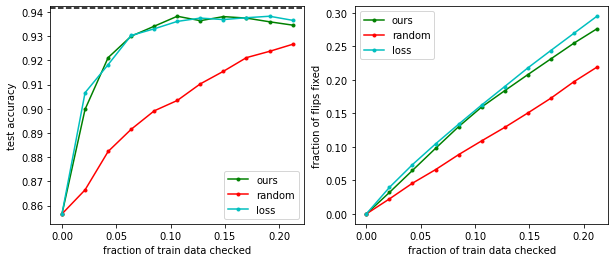

In [15]:
noise_detection(model_type='cb', encoding='tree_output', dataset='amazon', n_estimators=100, random_state=1)

train instances: 32561
test instances: 16281
num noisy labels: 12000

Before noise:
model (CatBoostClassifier)
test set acc: 0.868313
missed test instances (2144)
test log loss: 0.28596

After noise:
model (CatBoostClassifier)
test set acc: 0.831890
missed test instances (2737)
test log loss: 0.55850


100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


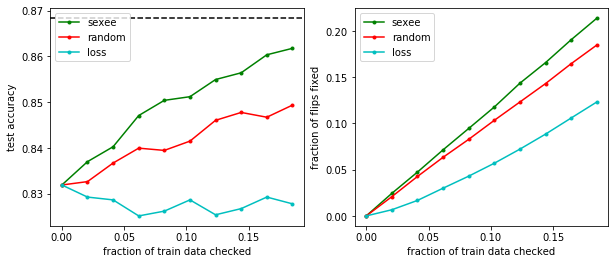

In [9]:
noise_detection(model_type='cb', encoding='tree_output', dataset='adult', n_estimators=100, random_state=1)

In [ ]:
noise_detection(model_type='cb', encoding='tree_output', dataset='medifor2', n_estimators=100, random_state=69, inf_k=None)